In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import floor

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, Dropout, Flatten, Reshape


%matplotlib inline 

In [102]:
path = "http://users.uoa.gr/~sdi1800133/emiris/dataset.csv"
input_csv = "/content/drive/MyDrive/Colab_Notebooks/7_eksamino/emiris/in.csv"
query_csv = "/content/drive/MyDrive/Colab_Notebooks/7_eksamino/emiris/q.csv"

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))


def get_dataset(path):
  df = pd.read_csv(path, index_col=0 , sep=r'\t', engine='python', header=None)

  return df

df = get_dataset(path)

df.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a,11.1440,10.4710,10.8280,10.6980,10.9100,10.9760,11.5770,11.9130,11.9060,12.2380,12.6430,12.8600,13.4410,13.2640,13.0360,12.6840,12.690,12.7520,12.7170,12.7710,12.9870,12.9870,13.2050,13.0010,12.8660,12.7520,12.6570,12.7710,13.0610,13.1980,13.1980,13.4410,13.7020,13.4930,14.372,14.6350,14.6940,14.216,14.6470,14.9520,...,65.946,66.036,65.956,65.787,65.647,64.599,63.98,64.26,63.8500,64.07,64.87,65.15,65.83,65.70,66.36,66.56,66.60,66.62,67.54,66.99,66.91,66.12,66.44,66.88,67.25,67.02,67.32,67.39,67.71,67.97,67.49,68.03,68.02,68.13,68.37,68.22,68.25,68.11,67.47,66.81
aa,47.4580,45.8700,46.2490,47.8520,49.5240,49.7790,50.9660,50.8400,50.1720,51.3840,52.8290,52.3440,54.2480,53.9490,54.1400,53.2420,54.183,54.4540,54.5740,53.4090,54.8710,55.5370,55.5370,55.0160,54.7880,52.3440,52.1200,51.1780,52.7000,52.3860,53.2420,53.2420,53.3040,52.8290,53.681,53.8870,53.1770,52.097,52.7640,52.4240,...,44.910,46.200,47.500,46.250,45.380,45.290,44.74,45.07,46.0800,46.62,47.65,48.31,47.91,48.25,47.49,47.07,46.89,46.94,47.53,47.71,48.24,47.77,47.75,46.54,47.93,47.93,50.08,49.52,49.15,47.91,47.42,47.78,47.70,47.46,47.12,47.29,46.97,45.89,43.33,43.01
aaba,13.8800,12.9700,13.2900,13.0900,13.4500,14.2400,14.9800,14.9500,15.0700,14.9200,14.3300,14.2800,14.7900,14.7000,13.9700,13.7500,13.950,14.8000,14.8500,14.3600,15.3300,15.7100,16.1500,15.8100,16.0700,15.7600,15.6800,15.6800,16.4300,16.1100,16.3500,16.8200,17.1800,17.4300,17.640,17.5500,17.6400,16.280,16.0900,16.1000,...,67.110,67.430,66.920,66.590,67.340,64.960,64.45,65.80,65.5803,66.24,66.51,67.81,67.66,67.72,67.85,68.74,68.93,69.22,67.91,67.52,68.04,66.78,67.79,67.45,67.51,66.51,66.61,65.40,65.57,67.52,68.86,70.12,70.59,70.51,70.23,71.71,72.22,71.16,70.19,70.56
aapl,1.2037,1.1589,1.1385,1.1437,1.1679,1.1731,1.2089,1.1704,1.1589,1.1487,1.1167,1.1078,1.1271,1.1294,1.0974,1.0744,1.100,1.1167,1.1371,1.1153,1.1691,1.1655,1.2241,1.2254,1.2294,1.2204,1.2026,1.2217,1.2347,1.1999,1.2204,1.2217,1.2334,1.2241,1.273,1.3065,1.2743,1.254,1.2717,1.2743,...,158.100,158.160,155.510,152.840,151.350,150.010,152.59,153.68,152.7300,153.57,153.26,153.92,152.93,154.83,154.74,155.28,155.34,155.99,155.44,156.43,159.31,159.90,159.19,155.42,155.69,155.61,156.54,155.85,156.85,162.47,166.12,168.43,166.29,167.51,171.88,173.63,174.18,175.61,175.25,174.67
abc,13.9910,13.4340,13.1950,13.4150,13.4710,13.4250,13.5920,13.7040,13.8990,14.2500,14.2450,14.2220,14.4960,15.2040,15.6960,15.1270,15.213,15.3580,15.3690,15.0610,15.6620,15.8540,15.6270,15.4360,15.9410,15.5330,15.4170,15.6140,15.9140,15.8410,15.7660,15.9410,16.1960,16.1830,16.665,16.4110,16.1550,15.691,15.7850,15.7940,...,80.670,79.280,79.500,80.380,81.050,80.980,82.00,82.43,80.9900,82.75,83.30,82.88,82.74,84.12,80.48,78.35,79.55,80.32,80.80,79.44,79.00,79.95,80.49,82.20,83.21,82.53,81.85,82.22,78.77,76.38,76.93,76.95,76.62,73.23,74.80,74.86,74.91,75.01,75.27,75.00


In [100]:

split_percent = floor(df.shape[1] * 0.8)          # the first 80% samples will train and the last 20% will validate 


train_set = df.values
train_set = train_set.flatten()

## use minMax Scaler
scaled = scaler.fit_transform(train_set.reshape(-1,1))
scaled.shape


(1310350, 1)

In [61]:
def split_intervals(input, n_timestamps):
  X = []
  y = []
  len = input.shape[0]

  for i in range(n_timestamps, len, n_timestamps):
    X.append(input[i-n_timestamps:i])
    y.append(input[i])

  X = np.array(X)
  y = np.array(y)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  y = np.reshape(y, (y.shape[0], 1))
  return X, y

In [62]:
n_timestamps = 50

input = scaled

X, y = split_intervals(input, n_timestamps)
print(X.shape, y.shape)

(26206, 50, 1) (26206, 1)


In [66]:
class NeuralNet:
  def __init__(self, n_epochs, batch_siz, n_timestamps, n_units, X_shapes, latent_dim=3):
    self.epochs = n_epochs
    self.batch_size = batch_siz


    input_window = keras.Input(shape=(n_timestamps,1))

    #encoding
    x = Conv1D(filters= n_units, kernel_size=3, activation='relu' , padding='same')(input_window)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    x = Conv1D(filters= n_units/2, kernel_size=2, activation='relu' , padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)


    # encoded model here
    x = Flatten()(x)       # flat
    x = Dense(latent_dim)(x)

    x = Reshape((latent_dim, 1))(x)
    # save the encoded model
    self.encoder = Model(input_window, x)
    
    #x = Reshape((latent_dim, 1))(x)

    # decoding
    #x = Conv1D(filters= n_units/2, kernel_size=3, activation='relu' , padding='same')(x)
    #x = Dropout(0.2)(x)
    #x = UpSampling1D(2)(x)

    #x = Conv1D(filters= n_units, kernel_size=3, activation='relu' , padding='same')(x)
    #x = Dropout(0.2)(x)
    #x = UpSampling1D(2)(x)

    #x = Conv1D(filters= 1, kernel_size=3, activation='sigmoid' , padding='same')(x)
    
    #self.autoencoder = Model(input_window, x)
    #self.autoencoder.summary()

  def compile_fit_encoder(self, X ,y , optimize='adam', loss_fun='mean_squared_error'):

    self.encoder.compile(optimizer=optimize, loss=loss_fun)

    history = self.encoder.fit(X, y, epochs = self.epochs, batch_size = self.batch_size,  validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')])
    return history
  
  def compile_fit_autoencoder(self, X ,y , optimize='adam', loss_fun='mean_squared_error'):

    self.autoencoder.compile(optimizer=optimize, loss=loss_fun)

    history = self.autoencoder.fit(X, y, epochs = self.epochs, batch_size = self.batch_size,  validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')])
    return history
  
  def predict(self, X_test):
    return self.encoder.predict(X_test)



In [67]:
n_epochs = 50
batch_size = 256
n_filters = 16


neuralnet = NeuralNet(n_epochs, batch_size, n_timestamps, n_filters, X.shape,4)
history = neuralnet.compile_fit_encoder(X, y)


Epoch 1/50
93/93 [==============================] - 2s 15ms/step - loss: 2.9077e-04 - val_loss: 2.2409e-06
Epoch 2/50
93/93 [==============================] - 1s 13ms/step - loss: 7.5931e-05 - val_loss: 7.8155e-07
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 7.9719e-05 - val_loss: 5.4975e-07
Epoch 4/50
93/93 [==============================] - 1s 14ms/step - loss: 7.9395e-05 - val_loss: 1.1322e-07
Epoch 5/50
93/93 [==============================] - 1s 13ms/step - loss: 6.9608e-05 - val_loss: 1.3173e-07
Epoch 6/50
93/93 [==============================] - 1s 13ms/step - loss: 6.1843e-05 - val_loss: 7.0060e-07


In [103]:
compressed_timeseries = []
for i in range(df.shape[0]):
  input = scaler.fit_transform(df.iloc[i].values.reshape(-1,1))      # use minMax scaler

  X_test, y_test = split_intervals(input, n_timestamps)
  predictions = neuralnet.predict(X_test)

  X_test = X_test[:,:,0]
  predictions = predictions[:,:,0]

  predicted_stock_price = scaler.inverse_transform(predictions)     # get the non-scaled values of predicted
  predicted_stock_price = predicted_stock_price.ravel()
  compressed_timeseries.append(predicted_stock_price)

compressed_df = pd.DataFrame(compressed_timeseries)
compressed_df.iloc[:349].to_csv(input_csv)
compressed_df.iloc[349:].to_csv(query_csv)

In [107]:

# function to compute learning curve and plot
def learning_curves(history ,title):
  
  plt.plot(history.history['loss'], label = 'Training loss', linestyle = '-', marker='o')
  plt.plot(history.history['val_loss'], label = 'Validation loss',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('loss', fontsize = 10)
  plt.xlabel('epoch', fontsize = 10)
  plt.title(title, fontsize = 14, y = 1.03)
  plt.legend()


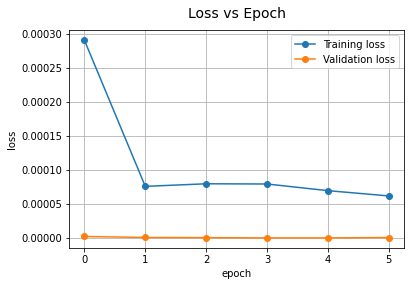

In [108]:
learning_curves(history, "Loss vs Epoch")

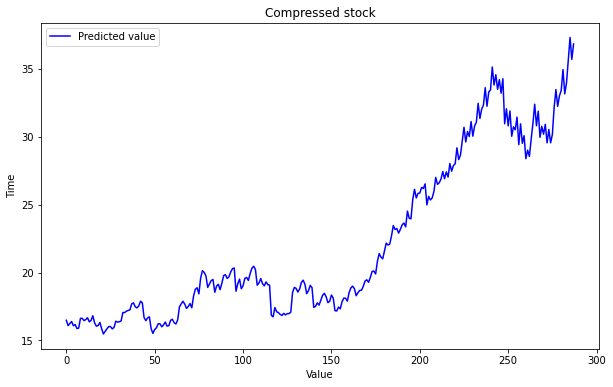

In [104]:
## HERE we do a plot to see one compressed timeseries vs the real timeseries values below

i_stock = 5
input = scaler.fit_transform(df.iloc[i_stock].values.reshape(-1,1))      # use minMax scaler

X_test, y_test = split_intervals(input, n_timestamps)
predictions = neuralnet.predict(X_test)

X_test = X_test[:,:,0]
predictions = predictions[:,:,0]

predicted_stock_price = scaler.inverse_transform(predictions)     # get the non-scaled values of predicted
predicted_stock_price = predicted_stock_price.ravel()

plt.figure(figsize=(10,6))
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted value')
#plt.xticks(np.arange(0,900,50))
plt.title('Compressed stock')
plt.xlabel('Value')
plt.ylabel('Time')
plt.legend()
plt.show()  

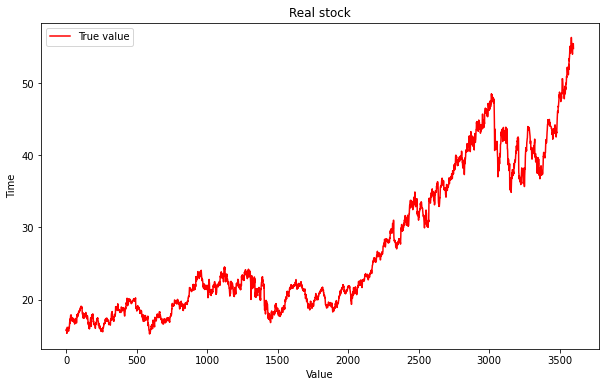

In [106]:
plt.figure(figsize=(10,6))
set_ = df.iloc[i_stock].values
x_axis_values = [(i) for i in range(len(set_[n_timestamps:]))]
plt.plot(x_axis_values,set_[n_timestamps:], color = 'red', label = 'True value')
plt.title('Real stock')
plt.xlabel('Value')
plt.ylabel('Time')
plt.legend()
plt.show()  